This fill creates some extra plots, used in the defence presentation

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import norm
import networkx as nx
import os
from zipfile import ZipFile
from matplotlib import colors as mcolors

In [2]:
label_fontsize = 16
tick_fontsize = 12
y_offset = 0.1

figure_path = os.path.join(os.path.dirname(os.getcwd()), 'figures', 'defence')

In [3]:
tasks = ['REST1', 'REST2', 'EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM']
rest_tasks = ['REST1', 'REST2']
encs = ['LR', 'RL']

In [4]:
## Extract 1 timeseries
subject = 'S1'
task = 'REST1'
ttype = 'r' if task in rest_tasks else 't'
enc = 'LR'

path_to_data = os.path.join(os.path.dirname(os.getcwd()), 'HCPdata')
with ZipFile(os.path.join(path_to_data, f"{subject}.zip"), 'r') as zfile:
    zfile.extractall()

timeseries = dict(np.load(f"timeseries_{ttype}fMRI_{task}_{enc}.npz"))['timeseries']
    
for task in tasks:
    for enc in encs:
        task_type = 'r' if task in rest_tasks else 't'
        filename = f"timeseries_{task_type}fMRI_{task}_{enc}.npz"
        os.remove(filename)

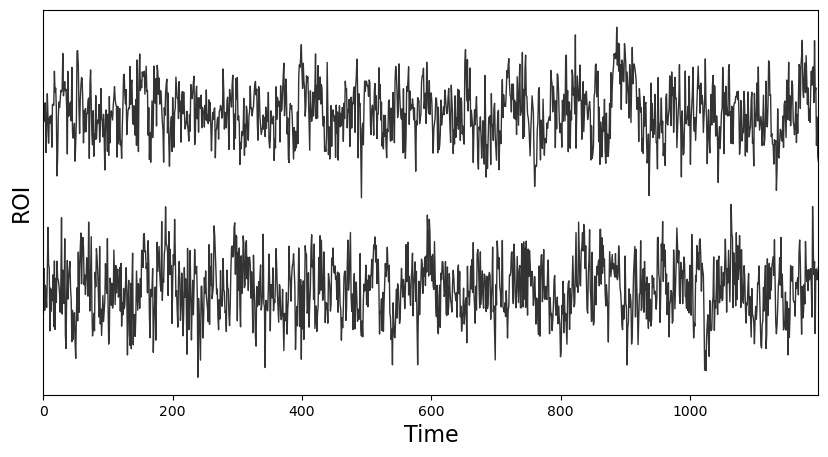

In [5]:
N, nT = timeseries.shape
t1, t2 = timeseries[:2,:]
## Normalize timeseries
t1n = t1/np.max(t1)
t2n = t2/np.max(t2)

## Plot the two series
plt.figure(figsize=(10, 5))
plt.plot(np.arange(nT), t1n, color='0.2', lw=1)
plt.plot(np.arange(nT), t2n+2+y_offset, color='0.2', lw=1)
plt.yticks([])
plt.ylabel('ROI', fontsize=label_fontsize)
plt.xlabel('Time', fontsize=label_fontsize)
plt.xlim((0, nT - 1))
savename = os.path.join(figure_path, "two_timeseries.png")
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
label_location = os.path.join(os.getcwd(), 'Labels', 'lobelabels.npz')

label_data = np.load(label_location)
plt_labels = label_data[label_data.files[0]]        
## Sort distance matrix by lobe
lobes = [l[1].split(';')[0] for l in plt_labels]
idc = np.argsort(lobes)

ordered = np.sort(lobes)
uordered = np.unique(ordered)
first_idc = [list(ordered).index(ul) for ul in uordered]

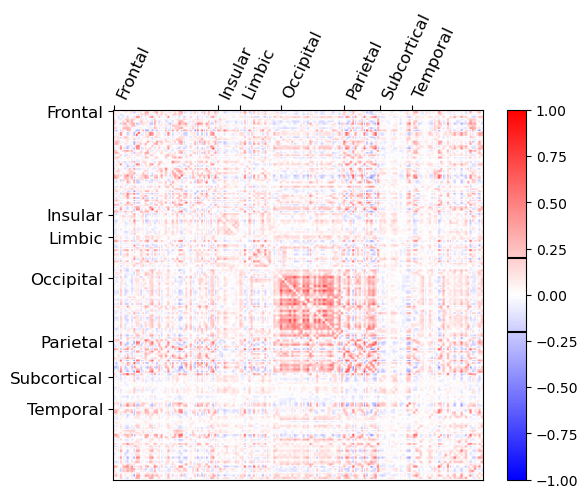

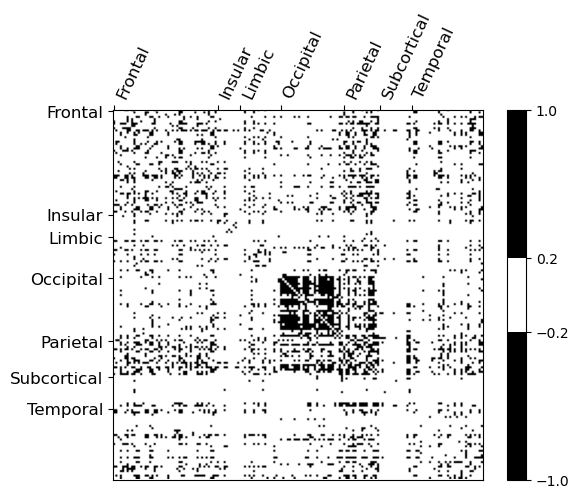

In [11]:
th = 0.20 # threshold

## Sort correlations
corr = np.corrcoef(timeseries)
np.fill_diagonal(corr, 0)

c_sorted = np.zeros((N, N))
for row in range(N):
    c_sorted[row] = corr[idc[row]][idc]
    
## Continuous matrix plot
c_im = plt.imshow(c_sorted, cmap='bwr', vmin=-1, vmax=1)
plt.yticks(ticks=first_idc, labels=uordered, fontsize=tick_fontsize)
plt.xticks(ticks=first_idc, labels=uordered, rotation=65, fontsize=tick_fontsize, ha='left')
plt.gca().xaxis.tick_top()
## Add colorbar with two lines at the threshold
cbar = plt.colorbar()
cbar.ax.axhline(th, c='k') 
cbar.ax.axhline(-th, c='k')
savename = os.path.join(figure_path, 'correlation.png')
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()

## Binary matrix plot
fig, ax = plt.subplots()
bin_adj = np.array(np.abs(c_sorted) > th, int)
ax.imshow(bin_adj, cmap='Greys', vmin=0, vmax=1)
## Make the range of correlations on the colorbar that align with edges black, and the rest white
cmap = mpl.colors.ListedColormap(['black', 'white', 'black'])
bounds = [-1, -th, th, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             orientation='vertical',
             ax=ax, 
             spacing='proportional')

plt.yticks(ticks=first_idc, labels=uordered, fontsize=tick_fontsize)
plt.xticks(ticks=first_idc, labels=uordered, rotation=65, fontsize=tick_fontsize, ha='left')
plt.gca().xaxis.tick_top()
savename = os.path.join(figure_path, 'binary.png')
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()

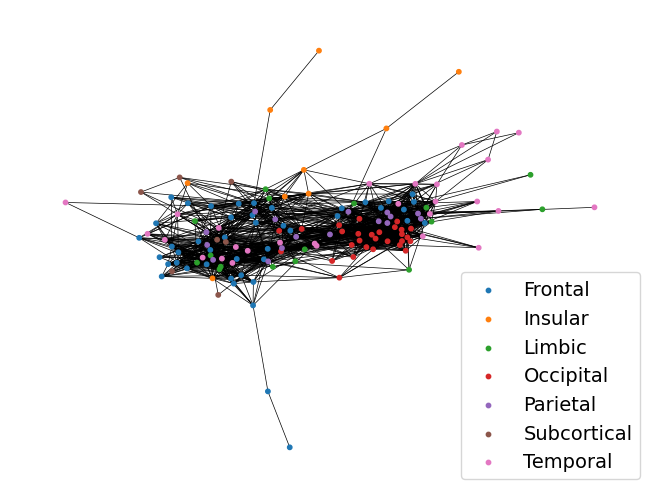

In [269]:
## Get graph and remove unconnected components
G = nx.from_numpy_array(bin_adj)
largest_component = max(nx.connected_components(G), key=len)
con_G = G.subgraph(largest_component)
removed = sorted(list(set(np.arange(N)).difference(largest_component)))

## Get the colors, taking the removed nodes into account
last_idc_plus_one = [i for i in first_idc[1:]] + [N+1]
n_elems = [last_idc_plus_one[0]-1]+[j-i for i, j in zip(last_idc_plus_one[:-1], last_idc_plus_one[1:])]
ncolors = list(mcolors.TABLEAU_COLORS.keys())[:len(n_elems)]
_colors = np.repeat(ncolors, n_elems)
node_colors = np.delete(_colors, removed)

## Draw the network
nx.draw_spring(con_G, node_size=10, node_color=node_colors, width=0.5)
xmin, xmax = plt.xlim()

for i, c in enumerate(ncolors):
    plt.scatter(10*np.abs(xmax), 0, c=c, s=10, label=uordered[i])

plt.xlim(xmin, xmax)
plt.legend(fontsize=14)
savename = os.path.join(figure_path, 'graph.png')
plt.savefig(savename, bbox_inches='tight', transparent=True)
plt.show()

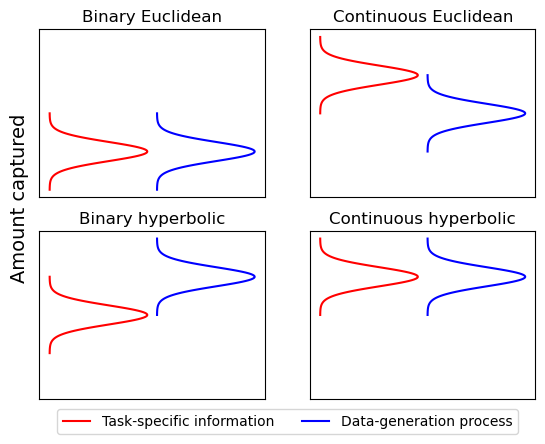

In [5]:
## Conceptual figures to explain the hypotheses
x_lim = 4
x_off = 1.1
y_inc = 8

fig, axes = plt.subplots(2,2, sharex='all', sharey='all')
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])

y = np.linspace(-x_lim, x_lim, 100)
dist = norm.pdf(y)
dist /= np.max(dist)

axes[0,0].plot(dist, y, 'r-')
axes[0,0].plot(dist+x_off, y, 'b-')
axes[0,0].set_title('Binary Euclidean')

axes[0,1].plot(dist, y+y_inc, 'r-')
axes[0,1].plot(dist+x_off, y+y_inc/2, 'b-')
axes[0,1].set_title('Continuous Euclidean')

axes[1,0].plot(dist, y+y_inc/2, 'r-')
axes[1,0].plot(dist+x_off, y+y_inc, 'b-')
axes[1,0].set_title('Binary hyperbolic')

axes[1,1].plot(dist, y+y_inc, 'r-', label='Task-specific information')
axes[1,1].plot(dist+x_off, y+y_inc, 'b-', label='Data-generation process')
axes[1,1].set_title('Continuous hyperbolic')
axes[1,1].legend(loc='lower center', bbox_to_anchor=(-0.1, -0.25), ncol=2)

axes[0,0].set_ylabel('Amount captured', y=0, fontsize=14)
savename = os.path.join(figure_path, 'model_design.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

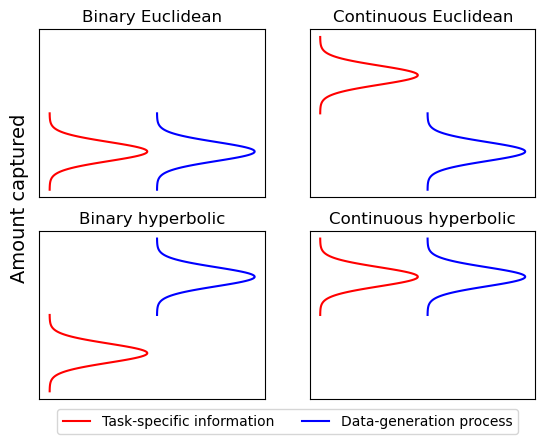

In [7]:
x_lim = 4
x_off = 1.1
y_inc = 8

fig, axes = plt.subplots(2,2, sharex='all', sharey='all')
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])

y = np.linspace(-x_lim, x_lim, 100)
dist = norm.pdf(y)
dist /= np.max(dist)

axes[0,0].plot(dist, y, 'r-')
axes[0,0].plot(dist+x_off, y, 'b-')
axes[0,0].set_title('Binary Euclidean')

axes[0,1].plot(dist, y+y_inc, 'r-')
axes[0,1].plot(dist+x_off, y, 'b-')
axes[0,1].set_title('Continuous Euclidean')

axes[1,0].plot(dist, y, 'r-')
axes[1,0].plot(dist+x_off, y+y_inc, 'b-')
axes[1,0].set_title('Binary hyperbolic')

axes[1,1].plot(dist, y+y_inc, 'r-', label='Task-specific information')
axes[1,1].plot(dist+x_off, y+y_inc, 'b-', label='Data-generation process')
axes[1,1].set_title('Continuous hyperbolic')
axes[1,1].legend(loc='lower center', bbox_to_anchor=(-0.1, -0.25), ncol=2)

axes[0,0].set_ylabel('Amount captured', y=0, fontsize=14)
savename = os.path.join(figure_path, 'model_design_alt.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

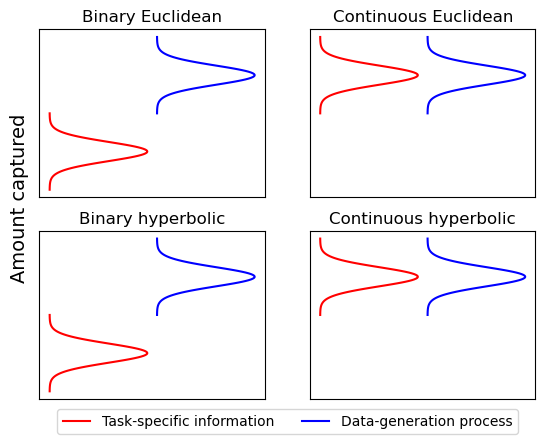

In [11]:
x_lim = 4
x_off = 1.1
y_inc = 8

fig, axes = plt.subplots(2,2, sharex='all', sharey='all')
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])

y = np.linspace(-x_lim, x_lim, 100)
dist = norm.pdf(y)
dist /= np.max(dist)

axes[0,0].plot(dist, y, 'r-')
axes[0,0].plot(dist+x_off, y+y_inc, 'b-')
axes[0,0].set_title('Binary Euclidean')

axes[0,1].plot(dist, y+y_inc, 'r-')
axes[0,1].plot(dist+x_off, y+y_inc, 'b-')
axes[0,1].set_title('Continuous Euclidean')

axes[1,0].plot(dist, y, 'r-')
axes[1,0].plot(dist+x_off, y+y_inc, 'b-')
axes[1,0].set_title('Binary hyperbolic')

axes[1,1].plot(dist, y+y_inc, 'r-', label='Task-specific information')
axes[1,1].plot(dist+x_off, y+y_inc, 'b-', label='Data-generation process')
axes[1,1].set_title('Continuous hyperbolic')
axes[1,1].legend(loc='lower center', bbox_to_anchor=(-0.1, -0.25), ncol=2)

axes[0,0].set_ylabel('Amount captured', y=0, fontsize=14)
savename = os.path.join(figure_path, 'hyps_revisited_alt.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

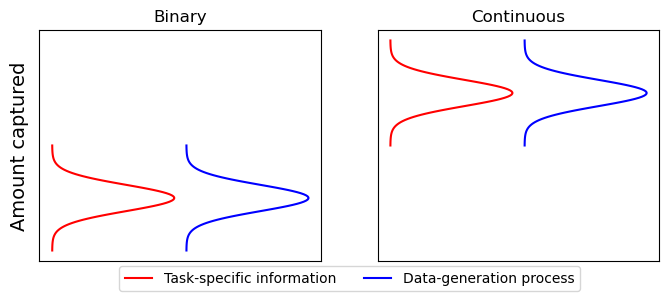

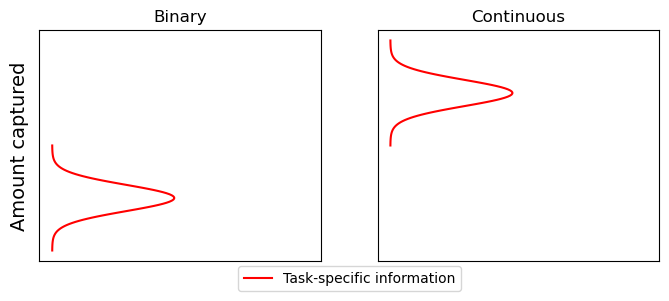

In [5]:
y_lim = 4
x_off = 1.1
y_inc = 8

fig, axes = plt.subplots(1,2, sharex='all', sharey='all', figsize=(8,3))
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])

y = np.linspace(-y_lim, y_lim, 100)
dist = norm.pdf(y)
dist /= np.max(dist)

axes[0].plot(dist, y, 'r-')
axes[0].plot(dist+x_off, y, 'b-')
axes[0].set_title('Binary')
axes[0].set_ylabel('Amount captured', fontsize=14)

axes[1].plot(dist, y+y_inc, 'r-', label='Task-specific information')
axes[1].plot(dist+x_off, y+y_inc, 'b-', label='Data-generation process')
axes[1].set_title('Continuous')
axes[1].legend(loc='lower center', bbox_to_anchor=(-0.1, -0.16), ncol=2)
xmin, xmax = plt.xlim()
savename = os.path.join(figure_path, 'confound2.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

fig, axes = plt.subplots(1,2, sharex='all', sharey='all', figsize=(8,3))
for ax in axes.ravel():
    ax.set_yticks([])
    ax.set_xticks([])
axes[0].plot(dist, y, 'r-')
axes[0].set_title('Binary')
axes[0].set_ylabel('Amount captured', fontsize=14)
axes[0].set_xlim(xmin, xmax)

axes[1].plot(dist, y+y_inc, 'r-', label='Task-specific information')
axes[1].set_xlim(xmin, xmax)
axes[1].set_title('Continuous')
axes[1].legend(loc='lower center', bbox_to_anchor=(-0.1, -0.16), ncol=2)
savename = os.path.join(figure_path, 'confound1.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

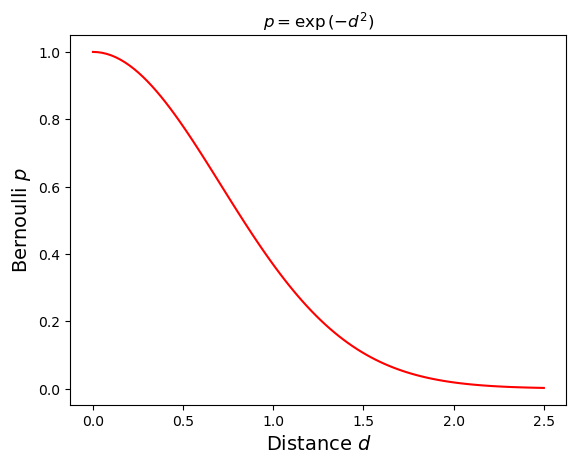

In [68]:
## Distance to Bernoulli p mapping function
d = np.linspace(0, 2.5, 100)
p = np.exp(-d**2)

plt.plot(d, p, 'r-')
plt.xlabel(r'Distance $d$', fontsize=14)
plt.ylabel(r'Bernoulli $p$', fontsize=14)
plt.title(r'$p = \exp\left(-d^2\right)$')
savename = os.path.join(figure_path, 'd_to_p_mapping.png')
plt.savefig(savename, bbox_inches='tight', transparent=True, dpi=1200)
plt.show()